# Dataset Input Pipeline Experiments

In [1]:
import os
import sys
import cv2
import glob
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

from collections import namedtuple

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.4.1


In [2]:
def get_labels():

    # a label and all meta information
    Label = namedtuple( 'Label' , [

        'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                        # We use them to uniquely name a class

        'id'          , # An integer ID that is associated with this label.
                        # The IDs are used to represent the label in ground truth images
                        # An ID of -1 means that this label does not have an ID and thus
                        # is ignored when creating ground truth images (e.g. license plate).
                        # Do not modify these IDs, since exactly these IDs are expected by the
                        # evaluation server.

        'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                        # ground truth images with train IDs, using the tools provided in the
                        # 'preparation' folder. However, make sure to validate or submit results
                        # to our evaluation server using the regular IDs above!
                        # For trainIds, multiple labels might have the same ID. Then, these labels
                        # are mapped to the same class in the ground truth images. For the inverse
                        # mapping, we use the label that is defined first in the list below.
                        # For example, mapping all void-type classes to the same ID in training,
                        # might make sense for some approaches.
                        # Max value is 255!

        'category'    , # The name of the category that this label belongs to

        'categoryId'  , # The ID of this category. Used to create ground truth images
                        # on category level.

        'hasInstances', # Whether this label distinguishes between single instances or not

        'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                        # during evaluations or not

        'color'       , # The color of this label
        ] )


    #--------------------------------------------------------------------------------
    # A list of all labels
    #--------------------------------------------------------------------------------

    labels = [
        #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
        Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
        Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
        Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
        Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
        Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
        Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
        Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
        Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
        Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
        Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
        Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
        Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
        Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
        Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
        Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
        Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
        Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
        Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
        Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
        Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
        Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
        Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
        Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
        Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
        Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
        Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
        Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
        Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
        Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
        Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
        Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
        Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
        Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
        Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
        Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
    ]

    return labels

In [3]:
labels = get_labels() # a list of named tuples

split_type = "train"

config = {
    'cityscapes_dir': 'cityscapes',
    'trainval_input_pattern': '*_leftImg8bit.png',
    'trainval_annot_pattern': '*_gtFine_labelTrainIds.png',
    'trainval_image_dir': 'leftImg8bit',
    'trainval_label_dir': 'gtFine',
    
    'n_classes': 19,
    'height': 384,
    'width': 768,
    'batch_size': 4,
    'label_tuples': labels,
    'ignore_label': 255, 
    
    'channel_mean': np.array([0.485, 0.456, 0.406]),
    'channel_std': np.array([0.229, 0.224, 0.225])
}


id2label = { label.id : label for label in labels }
catid2label = { label.categoryId : label for label in labels }
trainid2label = { label.trainId : label for label in labels }

In [4]:
search_image_files = os.path.join(
    config['cityscapes_dir'],
    config['trainval_image_dir'], 
    split_type, '*', 
    config['trainval_input_pattern'])

search_annot_files = os.path.join(
    config['cityscapes_dir'],
    config['trainval_label_dir'], 
    split_type, '*', 
    config['trainval_annot_pattern'])

In [5]:
def label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for val, key in trainid2label.items():
        indices = mask == val
        mask_rgb[indices.squeeze()] = key.color 
    return mask_rgb

def display(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
# scales = tf.convert_to_tensor(np.array([0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75]))
# scales[tf.random.uniform(shape=[], minval=0, maxval=9, dtype=tf.int32)]

In [7]:
def random_flip(image, mask):
    if np.random.random_sample() > 0.5:
        image = image[:, ::-1, :]
        mask = mask[:, ::-1, :]
    return image, mask

    
def random_crop(image, mask):
    image = tf.convert_to_tensor(image)
    mask = tf.convert_to_tensor(mask)

    scales = tf.convert_to_tensor(np.array([0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75]))
    scale = scales[tf.random.uniform(shape=[], minval=0, maxval=9, dtype=tf.int32)]
    scale = tf.cast(scale, tf.float32)

    shape = tf.cast(tf.shape(image), tf.float32)
    h = tf.cast(shape[0] * scale, tf.int32)
    w = tf.cast(shape[1] * scale, tf.int32)
    combined_tensor = tf.concat([image, mask], axis=2)
    combined_tensor = tf.image.random_crop(combined_tensor, size=[h, w, 4])
    image = combined_tensor[:,:,0:3].numpy()
    mask = combined_tensor[:,:,-1].numpy()
    return image, mask


def normalize(image, mask):
    
    C_means = config['channel_mean']
    C_stds = config['channel_std']
    
    image = image / 255

    R_MEAN, G_MEAN, B_MEAN = C_means[0], C_means[1], C_means[2]
    R_STD, G_STD, B_STD = C_stds[0], C_stds[1], C_stds[2]

    image[:,:,0] = image[:,:,0] - R_MEAN
    image[:,:,1] = image[:,:,1] - G_MEAN
    image[:,:,2] = image[:,:,2] - B_MEAN

    image[:,:,0] = image[:,:,0] / R_STD
    image[:,:,1] = image[:,:,1] / G_STD
    image[:,:,2] = image[:,:,2] / B_STD

    return image, mask


def augmentation_ops(image, mask):

    H = config['height']
    W = config['width']
    crop_size = (H, W)

    image, mask = random_flip(image, mask)

    # image, mask = random_crop(image, mask, crop_size)
    image, mask = random_crop(image, mask)
    
    img_size = (W, H)
    image = cv2.resize(image, img_size, img_size, interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, img_size, img_size, interpolation=cv2.INTER_NEAREST)

    image, mask = normalize(image, mask)
    # mask = self.convert_label(mask)[:, :, 0]
    return image.astype(np.float32), mask.astype(np.float32)

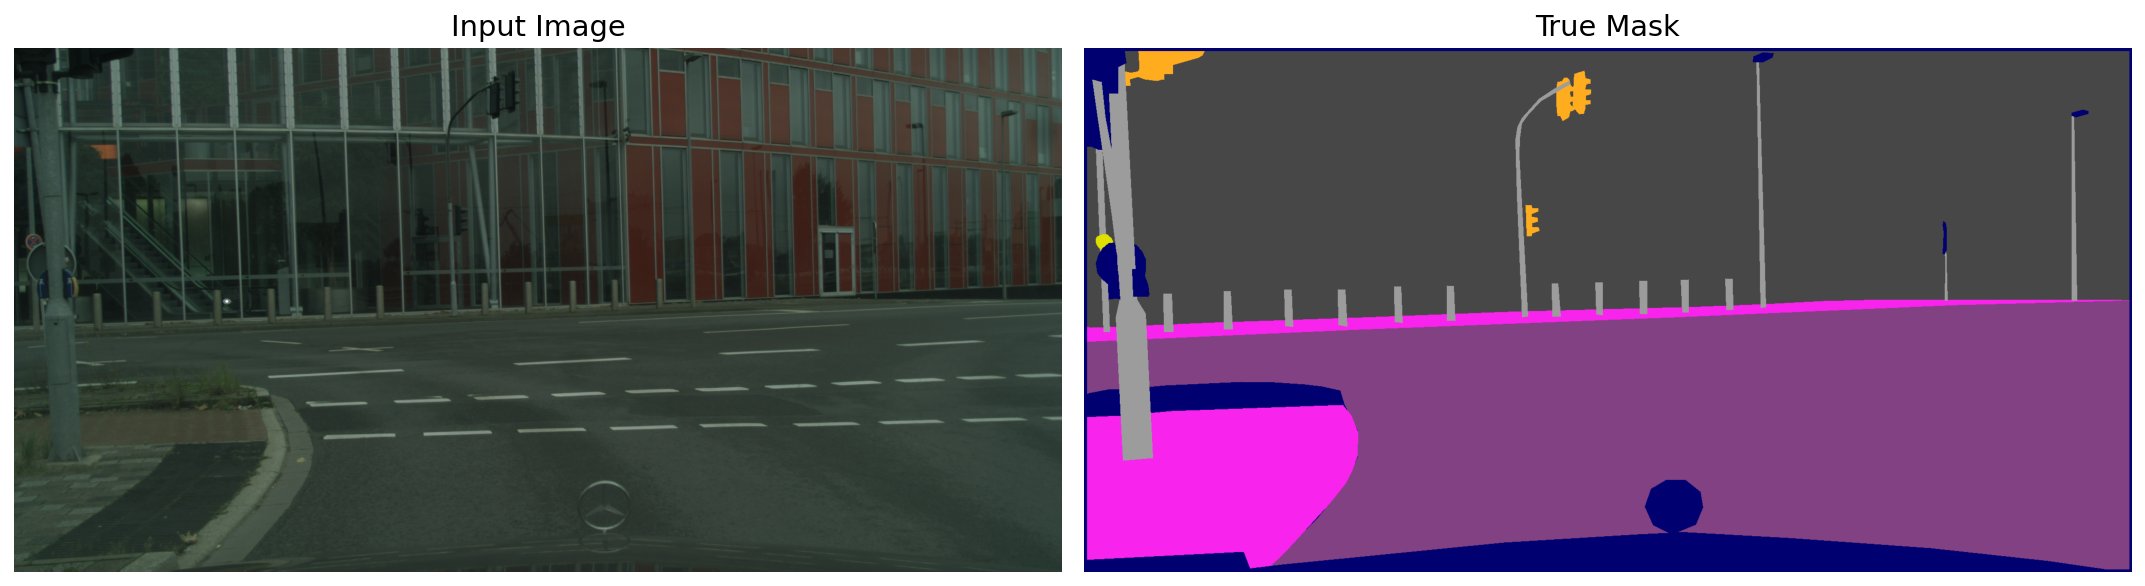

In [8]:
image_list = sorted(glob.glob(search_image_files))
mask_list = sorted(glob.glob(search_annot_files))
assert len(image_list) == len(mask_list)

length_tot = len(image_list)
index_list = np.arange(0, length_tot)
rng = np.random.default_rng()
index_list = rng.permutation(index_list)

idx = index_list[27]
image = img_to_array(load_img(image_list[idx]))
mask = img_to_array(load_img(mask_list[idx], color_mode = "grayscale"))

mask_rgb = label_to_rgb(mask)
display([image, mask_rgb])

image_aug, mask_aug = augmentation_ops(image, mask)
display([image_aug, label_to_rgb(mask_aug)])

In [9]:
class DataLoader():
    
    def __init__ (self, config, split_type, augment=True):
        
        ### Get sorted lists of image / mask files ###
        search_image_files = os.path.join(
            config['cityscapes_dir'],
            config['trainval_image_dir'], 
            split_type, '*', 
            config['trainval_input_pattern'])

        search_annot_files = os.path.join(
            config['cityscapes_dir'],
            config['trainval_label_dir'], 
            split_type, '*', 
            config['trainval_annot_pattern'])
        
        self.image_list = sorted(glob.glob(search_image_files))
        self.mask_list = sorted(glob.glob(search_annot_files))
        assert len(self.image_list) == len(self.mask_list)
        
        self.length_total = len(self.image_list)
        self.index_list = np.arange(0, self.length_total).tolist()
        
        ### Get different label mappings ###
        label_tuples = config['label_tuples'] # a list of named tuples
        self.id2label = { label.id : label for label in label_tuples }
        self.trainid2label = { label.trainId : label for label in label_tuples }
        self.catid2label = { label.categoryId : label for label in label_tuples }
        self.ignore_label = config['ignore_label']
        
        ### Extract other parameters ###
        self.n_classes = config['n_classes']
        self.batch_size = config['batch_size']
        self.img_height = config['height']
        self.img_width = config['width']
        
        self.mean = config['channel_mean']
        self.std = config['channel_std']
        
        self.augment = augment
        self.config = config
        self.offset = 0
        
        ### Randomly shuffle the dataset ###
        self.on_epoch_end()

        
    @property
    def steps(self):
        # returns the number of batches
        return self.length_total / self.batch_size
    
    
    def random_flip(self, image, mask):
        if np.random.random_sample() > 0.5:
            image = image[:, ::-1, :]
            mask = mask[:, ::-1, :]
        return image, mask
    
    
    def random_crop(self, image, mask, crop_size):
        H = crop_size[0]
        W = crop_size[1]
        
        mh = image.shape[0] - H
        mw = image.shape[1] - W
        
        if mh == 0 and mw == 0: 
            return image, mask
        
        rmh = np.random.randint(0, mh)
        rmw = np.random.randint(0, mw)
        
        image = image[rmh:rmh + H, rmw:rmw + W, :]
        mask = mask[rmh:rmh + H, rmw:rmw + W, :]
        
        return image, mask
    
    
    def normalize(self, image, mask):
         
        R_MEAN, G_MEAN, B_MEAN = self.mean[0], self.mean[1], self.mean[2]
        R_STD, G_STD, B_STD = self.std[0], self.std[1], self.std[2]
        
        image = image / 255.0
        
        image[:,:,0] = image[:,:,0] - R_MEAN
        image[:,:,1] = image[:,:,1] - G_MEAN
        image[:,:,2] = image[:,:,2] - B_MEAN
        
        image[:,:,0] = image[:,:,0] / R_STD
        image[:,:,1] = image[:,:,1] / G_STD
        image[:,:,2] = image[:,:,2] / B_STD
        
        return image, mask
    
    
    def augmentation_ops(self, image, mask):

        H = self.img_height
        W = self.img_width
        crop_size = (H, W)

        if self.augment:
            image, mask = self.random_flip(image, mask)
            image, mask = self.random_crop(image, mask, crop_size)
                
        img_size = (W, H)
        image = cv2.resize(image, img_size, img_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, img_size, img_size, interpolation=cv2.INTER_NEAREST)
                
        image, mask = self.normalize(image, mask)

        return image.astype(np.float32), mask.astype(np.float32)
    
    
    def get_one_set(self, idx):
        image = img_to_array(load_img(self.image_list[idx]))
        mask = img_to_array(load_img(self.mask_list[idx], color_mode = "grayscale"))
        image, mask = self.augmentation_ops(image, mask)
        return image, mask
    
    
    def get_batch(self):
        image_batch, mask_batch = [], []

        for i in range(self.batch_size):
            image, mask = self.get_one_set(self.offset + i)
            image_batch.append(image)
            mask_batch.append(mask)

        self.offset += self.batch_size
        return np.array(image_batch), np.array(mask_batch)
    
    
    def generator(self):
        
        for i in range(len(self.index_list)):
            image, mask = self.get_one_set(i)
            yield image, mask
            
        self.on_epoch_end()


    def on_epoch_end(self):
        rng = np.random.default_rng()
        self.index_list = rng.permutation(self.index_list)

In [10]:
train_loader = DataLoader(config=config, split_type='train', augment=True)
valid_loader = DataLoader(config=config, split_type='val', augment=False)

In [11]:
image, mask = train_loader.get_one_set(idx=27)
display([image, label_to_rgb(mask)])
image, mask = valid_loader.get_one_set(idx=27)
display([image, label_to_rgb(mask)])

In [12]:
image_batch, mask_batch = train_loader.get_batch()
print(image_batch.shape, mask_batch.shape)

(4, 384, 768, 3) (4, 384, 768)


In [13]:
train_ds = tf.data.Dataset.from_generator(
    train_loader.generator,
    (tf.float32, tf.float32),
    (tf.TensorShape([None, None, 3]), tf.TensorShape([None, None]))
).batch(config["batch_size"], drop_remainder=True)

valid_ds = tf.data.Dataset.from_generator(
    valid_loader.generator,
    (tf.float32, tf.float32),
    (tf.TensorShape([None, None, 3]), tf.TensorShape([None, None]))
).batch(config["batch_size"], drop_remainder=True)

In [14]:
for image_batch, mask_batch in train_ds.take(3):
    print(image_batch.shape, mask_batch.shape, np.mean(image_batch.numpy()), np.std(image_batch.numpy()))

sample_image_batch, sample_mask_batch = image_batch.numpy(), mask_batch.numpy()

(4, 384, 768, 3) (4, 384, 768) -0.85585886 0.6517015
(4, 384, 768, 3) (4, 384, 768) -0.74097824 0.35570416
(4, 384, 768, 3) (4, 384, 768) -0.8451122 0.81292033


In [15]:
for image_batch, mask_batch in valid_ds.take(3):
    print(image_batch.shape, mask_batch.shape, np.mean(image_batch.numpy()), np.std(image_batch.numpy()))

sample_image_batch, sample_mask_batch = image_batch.numpy(), mask_batch.numpy()

(4, 384, 768, 3) (4, 384, 768) -0.37903342 1.1341971
(4, 384, 768, 3) (4, 384, 768) -0.46209586 1.004495
(4, 384, 768, 3) (4, 384, 768) -0.5267541 0.9722081


In [16]:
sample_image = sample_image_batch[0]
sample_mask = sample_mask_batch[0]

display([sample_image, label_to_rgb(sample_mask)])

In [17]:
np.mean(sample_image_batch)

-0.5267541

In [ ]:
np.std(sample_image_batch)

In [ ]:
np.max(sample_image_batch)

In [ ]:
np.min(sample_image_batch)